In [1]:
#Problem statement -- Based on the informations provided from the customer , classify whether they are eligible for Loan  

In [2]:
#Library importing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,log_loss
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
warnings.simplefilter('ignore')

In [4]:
train_data=pd.read_csv('F:/ML-2019/Loan/train.csv')
test_data=pd.read_csv('F:/ML-2019/Loan/test.csv')

In [5]:
print('Train:',train_data.shape)
print('Test:',test_data.shape)

Train: (614, 13)
Test: (367, 12)


In [6]:
#13 features are present ,and most of them are object data type.
#Many missing values are in most of the features
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 43.2+ KB


In [7]:
#the target variable - Loan status is object (Y/N) values
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [8]:
#Combining both test and train data
train_data['source']='train'
test_data['source']='test'
data=pd.concat([train_data,test_data],ignore_index=True)

In [9]:
#missing vlues count in the training data
#data.apply(lambda x: x.isnull().sum())
data.isnull().sum()

ApplicantIncome        0
CoapplicantIncome      0
Credit_History        79
Dependents            25
Education              0
Gender                24
LoanAmount            27
Loan_Amount_Term      20
Loan_ID                0
Loan_Status          367
Married                3
Property_Area          0
Self_Employed         55
source                 0
dtype: int64

In [10]:
#dividing the numerical and categorivcal coulms seperate 
numerical_col=data.select_dtypes(include=[np.number]).columns
categorical_col=data.select_dtypes(include=['object']).columns
print('Numerical :\n', numerical_col)
print('Categorical :\n', categorical_col)

Numerical :
 Index(['ApplicantIncome', 'CoapplicantIncome', 'Credit_History', 'LoanAmount',
       'Loan_Amount_Term'],
      dtype='object')
Categorical :
 Index(['Dependents', 'Education', 'Gender', 'Loan_ID', 'Loan_Status',
       'Married', 'Property_Area', 'Self_Employed', 'source'],
      dtype='object')


In [11]:
#Descriptive statistics - Central tendency / measures of variablity
#Applicant income and coapplicant income has no missing value , eventhough we can see the min value is 0 
    #-- Applicant with no income
#Applicant income is widely spread around the mean 
data.describe()

,ApplicantIncome,CoapplicantIncome,Credit_History,LoanAmount,Loan_Amount_Term
count,981.000000,981.000000,902.000000,954.000000,961.000000
mean,5179.795107,1601.916330,0.835920,142.511530,342.201873
std,5695.104533,2718.772806,0.370553,77.421743,65.100602
min,0.000000,0.000000,0.000000,9.000000,6.000000
25%,2875.000000,0.000000,1.000000,100.000000,360.000000
50%,3800.000000,1110.000000,1.000000,126.000000,360.000000
75%,5516.000000,2365.000000,1.000000,162.000000,360.000000
max,81000.000000,41667.000000,1.000000,700.000000,480.000000


In [12]:
#categorical variable describe
# we can see that most applicants are male and graduated with no dependent
data.describe(include=['object'])

,Dependents,Education,Gender,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed,source
count,956,981,957,981,614,978,981,926,981
unique,4,2,2,981,2,2,3,2,2
top,0,Graduate,Male,LP002776,Y,Yes,Semiurban,No,train
freq,545,763,775,1,422,631,349,807,614


In [13]:
# mostly gender have 3 values , mostly it will be the missing values
data.apply(lambda x : len(x.unique()))

ApplicantIncome      752
CoapplicantIncome    437
Credit_History         3
Dependents             5
Education              2
Gender                 3
LoanAmount           233
Loan_Amount_Term      13
Loan_ID              981
Loan_Status            3
Married                3
Property_Area          3
Self_Employed          3
source                 2
dtype: int64

In [14]:
#to check any duplicated entry (row)
data.duplicated().any()


False

In [15]:
data.Loan_ID.duplicated().any()

False

In [16]:
#The percentage of loan status - 43% applicants are eligible for the loan
data['Loan_Status'].value_counts()/len(data['Loan_Status'])

Y    0.430173
N    0.195719
Name: Loan_Status, dtype: float64

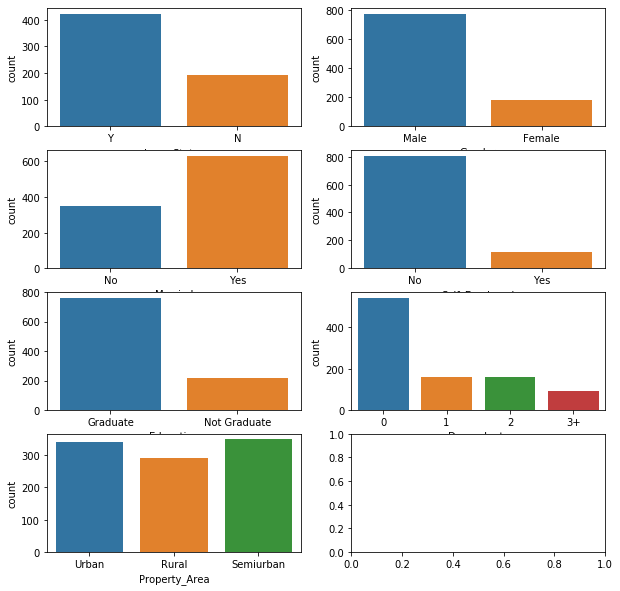

In [17]:
#Exploratory analysis - countable features
fig,axes=plt.subplots(4,2,figsize=(10,10))
sns.countplot('Loan_Status',data=data,ax=axes[0,0])
sns.countplot('Gender',data=data,ax=axes[0,1])
sns.countplot('Married',data=data,ax=axes[1,0])
sns.countplot('Self_Employed',data=data,ax=axes[1,1])
sns.countplot('Education',data=data,ax=axes[2,0])
sns.countplot('Dependents',data=data,ax=axes[2,1])
sns.countplot('Property_Area',data=data,ax=axes[3,0])
#More applicants are male, married, graduate,not self employed, with 0 dependents

In [18]:
#sns.distplot(data['ApplicantIncome'].dropna(),kde=True)

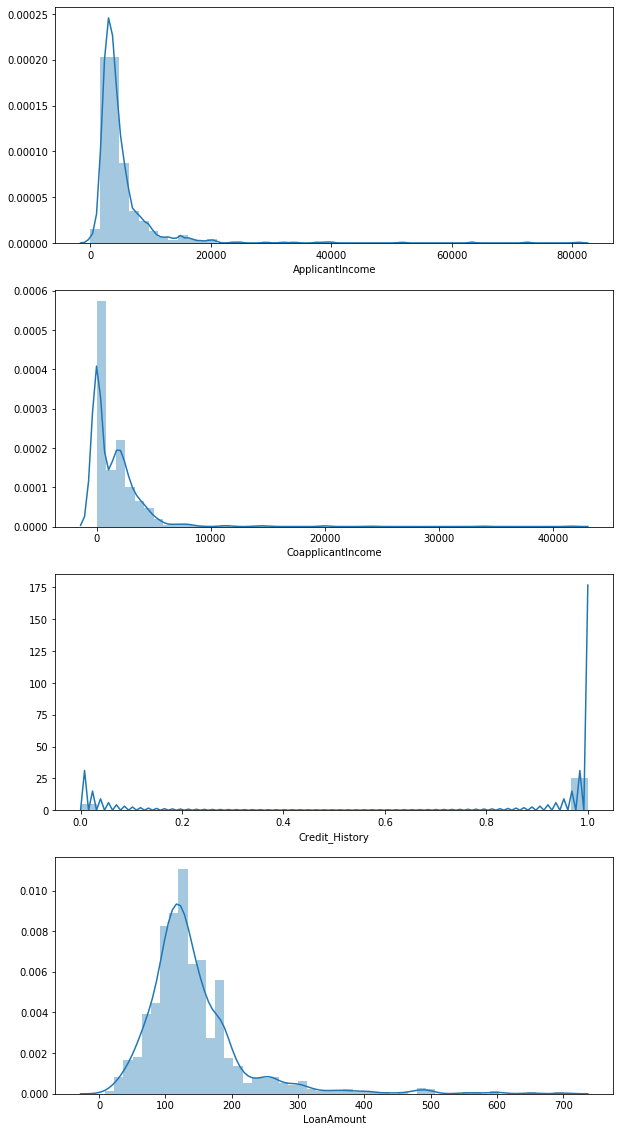

In [19]:
#non countable features
fig,axes=plt.subplots(4,1,figsize=(10,20))
for i,ax in enumerate(axes.flatten()):
    sns.distplot(data[numerical_col[i]].dropna(),kde=True,ax=ax)
#Most applicants are less income, and with good credit score
#Most applicants opted for less loan amount

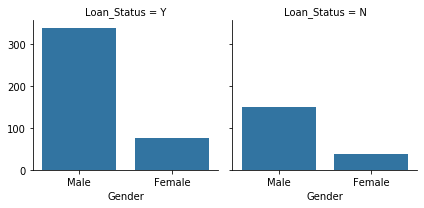

In [20]:
#Bi- variant anaysis
#counterplot--features
g=sns.FacetGrid(data,col='Loan_Status')
g.map(sns.countplot,'Gender')

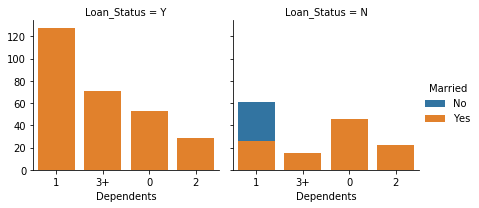

In [21]:
g=sns.FacetGrid(data,col='Loan_Status',hue='Married')
g.map(sns.countplot,'Dependents').add_legend()

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 14 columns):
ApplicantIncome      981 non-null int64
CoapplicantIncome    981 non-null float64
Credit_History       902 non-null float64
Dependents           956 non-null object
Education            981 non-null object
Gender               957 non-null object
LoanAmount           954 non-null float64
Loan_Amount_Term     961 non-null float64
Loan_ID              981 non-null object
Loan_Status          614 non-null object
Married              978 non-null object
Property_Area        981 non-null object
Self_Employed        926 non-null object
source               981 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 72.9+ KB


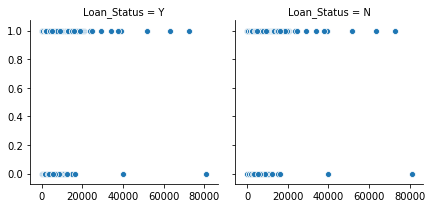

In [23]:
g=sns.FacetGrid(data,col='Loan_Status')
g.map(sns.scatterplot,x='ApplicantIncome',y='Credit_History',data=data).add_legend()

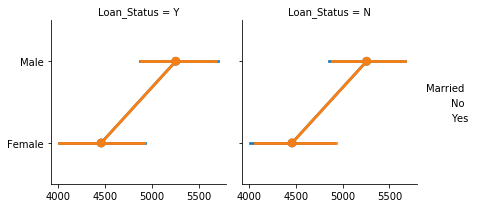

In [24]:
g=sns.FacetGrid(data,col='Loan_Status',hue='Married')
g.map(sns.pointplot,x='ApplicantIncome',y='Gender',data=data).add_legend()

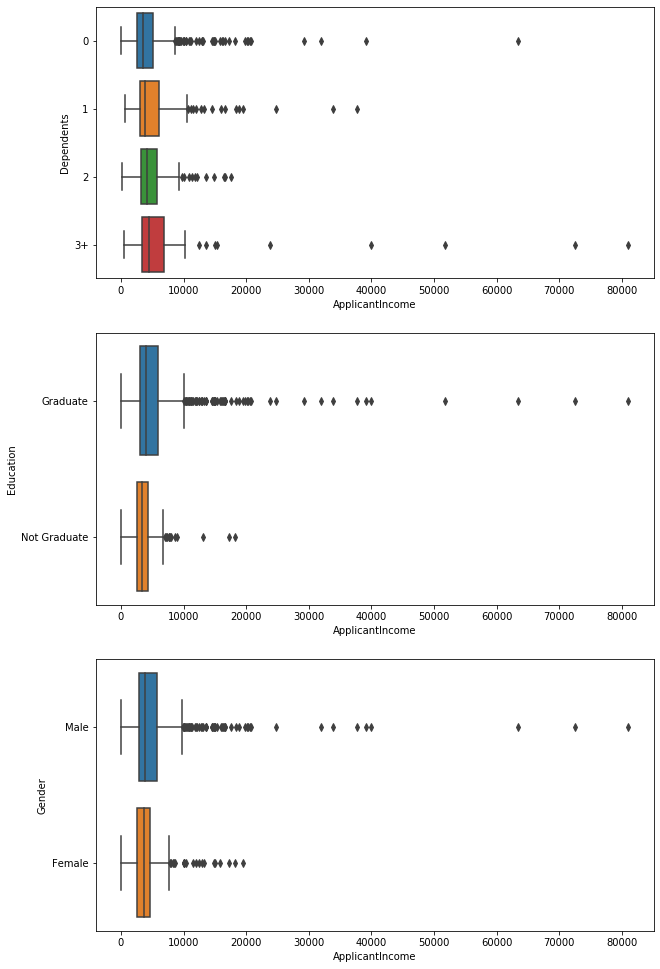

In [25]:
fig,axes=plt.subplots(3,1,figsize=(10,17))
for var,ax in zip(categorical_col,axes.flatten()):
    if var not in ['source','Loan_ID','Loan_Status']:
        sns.boxplot(x='ApplicantIncome',y=var,data=data,ax=ax)


(5.0, 0.0)

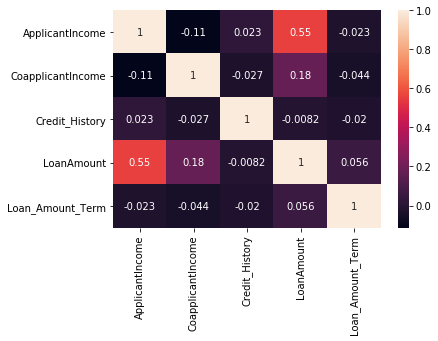

In [26]:
ax=sns.heatmap(data.corr(),annot=True)
bottom,top=ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
#Applicant income and loan amount has 0.55 correlation


In [27]:
#Convert all possible values of categorical to numerical
for var in categorical_col:
    if var not in ['Loan_ID','source']:
        print(var,'values:')
        print(data[var].unique())

Dependents values:
['0' '1' '2' '3+' nan]
Education values:
['Graduate' 'Not Graduate']
Gender values:
['Male' 'Female' nan]
Loan_Status values:
['Y' 'N' nan]
Married values:
['No' 'Yes' nan]
Property_Area values:
['Urban' 'Rural' 'Semiurban']
Self_Employed values:
['No' 'Yes' nan]


In [28]:
#All non missing features we can change 
data['Education']=data['Education'].map({'Graduate':1,'Not Graduate':0}).astype(int)
data['Education'].unique()

array([1, 0], dtype=int64)

In [29]:
data['Property_Area']=data['Property_Area'].map({'Urban':1,'Rural':2,'Semiurban':3}).astype(int)
data['Property_Area'].unique()

array([1, 2, 3], dtype=int64)

In [30]:
pvt=data.pivot_table(values='Married',columns='Loan_ID',aggfunc='sum')
pvt
#pvt.query(pvt.Married in ['Yes','No'])

Loan_ID,LP001002,LP001003,LP001005,LP001006,LP001008,LP001011,LP001013,LP001014,LP001015,LP001018,...,LP002974,LP002975,LP002978,LP002979,LP002980,LP002983,LP002984,LP002986,LP002989,LP002990
Married,No,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,No,Yes,No,Yes,Yes,Yes,No,No


In [31]:
pvt_coApplicant=data.pivot_table(values='CoapplicantIncome',columns='Loan_ID',aggfunc=lambda x:len(x)).astype(int)
pvt_coApplicant

Loan_ID,LP001002,LP001003,LP001005,LP001006,LP001008,LP001011,LP001013,LP001014,LP001015,LP001018,...,LP002974,LP002975,LP002978,LP002979,LP002980,LP002983,LP002984,LP002986,LP002989,LP002990
CoapplicantIncome,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [32]:
#Handling missing values of Dependents
print(data['Dependents'].isnull().sum())
def dependent_check(temp):
    dep=temp[0]
    identifier=temp[1]
    coApp=temp[2]
    if (pd.isnull(dep)):
        if (pvt[identifier][0] =='Yes'):
            return 1
        elif (pvt[identifier][0] =='No'):
        #print(identifier,pvt[identifier][0])
            return 0
        else:
            return pvt_coApplicant[identifier][0]
    else:
        return dep
#data[data.Dependents.isnull() & data.Married.notnull()]['Dependents']=data[data.Dependents.isnull() & data.Married.notnull()][['Dependents','Loan_ID']].apply(dependent_check,axis=1)
data['Dependents']=data[['Dependents','Loan_ID','CoapplicantIncome']].apply(dependent_check,axis=1)

25


In [33]:
print(data['Dependents'].isnull().sum())

0


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 14 columns):
ApplicantIncome      981 non-null int64
CoapplicantIncome    981 non-null float64
Credit_History       902 non-null float64
Dependents           981 non-null object
Education            981 non-null int32
Gender               957 non-null object
LoanAmount           954 non-null float64
Loan_Amount_Term     961 non-null float64
Loan_ID              981 non-null object
Loan_Status          614 non-null object
Married              978 non-null object
Property_Area        981 non-null int32
Self_Employed        926 non-null object
source               981 non-null object
dtypes: float64(4), int32(2), int64(1), object(7)
memory usage: 72.9+ KB


In [35]:
data['Credit_History'].fillna(data.Credit_History.median(),inplace=True)
data['Gender'].fillna(data.Gender.mode()[0],inplace=True)
data['LoanAmount'].fillna(data.LoanAmount.median(),inplace=True)
data['Loan_Amount_Term'].fillna(data.Loan_Amount_Term.median(),inplace=True)
data['Married'].fillna(data.Married.mode()[0],inplace=True)
data['Self_Employed'].fillna(data.Self_Employed.mode()[0],inplace=True)

In [36]:
#Median return only one value
data.Credit_History.median()
#Mode returns series
data.Gender.mode()

0    Male
dtype: object

In [37]:
#getting the null values
data[data['Gender'].isnull()]['Gender']

Series([], Name: Gender, dtype: object)

In [38]:
data.isnull().sum()

ApplicantIncome        0
CoapplicantIncome      0
Credit_History         0
Dependents             0
Education              0
Gender                 0
LoanAmount             0
Loan_Amount_Term       0
Loan_ID                0
Loan_Status          367
Married                0
Property_Area          0
Self_Employed          0
source                 0
dtype: int64

In [39]:
data.Loan_Status.unique()
data.Gender.value_counts()
data.Married.unique()
data.select_dtypes(include=['object']).columns

Index(['Dependents', 'Gender', 'Loan_ID', 'Loan_Status', 'Married',
       'Self_Employed', 'source'],
      dtype='object')

In [40]:
#Manualy giving encoder values using map
#Instead of this we can use LabelEncoder for categorical columns
#data.Gender=data.Gender.map({'Male':1,'Female':0}).astype(int)
#data.Married=data.Married.map({'No':1,'Yes':0}).astype(int)
le=LabelEncoder()
for col in categorical_col:
    if col not in ('Loan_ID','Loan_Status','source'):
        data[col]=le.fit_transform(data[col].astype(str))

#data=data.apply(lambda col:le.fit_transform(col.astype(str)) if col not in ('Loan_ID','Loan_Status','source') else col,axis=0)

In [41]:
data.head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed,source
0,5849,0.0,1.0,0,1,1,126.0,360.0,LP001002,Y,0,0,0,train
1,4583,1508.0,1.0,1,1,1,128.0,360.0,LP001003,N,1,1,0,train
2,3000,0.0,1.0,0,1,1,66.0,360.0,LP001005,Y,1,0,1,train
3,2583,2358.0,1.0,0,0,1,120.0,360.0,LP001006,Y,1,0,0,train
4,6000,0.0,1.0,0,1,1,141.0,360.0,LP001008,Y,0,0,0,train


In [42]:
#split the data to train ad test
train_data=data.loc[data['source']=='train']
test_data=data.loc[data['source']=='test']

In [43]:
train_data['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [44]:
train_data['Loan_Status']=train_data['Loan_Status'].map({'Y':1,'N':0}).astype(int)

In [45]:
train_data=train_data.drop('source',axis=1)
test_data=test_data.drop('source',axis=1)

In [46]:
#OneHotEncoder is mainly generate each specif value column 
#the main difference between panads' get_dummies is the get_dummies function can directly work on the string values- no need of labelencoder
#but for onehotencoder works only in integere values, so needs labelencoder
onehotencoder=OneHotEncoder(handle_unknown='ignore')
onehotencoder.fit_transform(train_data)
onehotencoder.fit_transform(train_data)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 13 columns):
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
Credit_History       614 non-null float64
Dependents           614 non-null int32
Education            614 non-null int32
Gender               614 non-null int32
LoanAmount           614 non-null float64
Loan_Amount_Term     614 non-null float64
Loan_ID              614 non-null object
Loan_Status          614 non-null int32
Married              614 non-null int32
Property_Area        614 non-null int32
Self_Employed        614 non-null int32
dtypes: float64(4), int32(7), int64(1), object(1)
memory usage: 48.0+ KB


In [47]:
#deciding the attributes
id='Loan_ID'
target='Loan_Status'
x=[x for x in train_data.columns if x not in target+id]
x


['ApplicantIncome',
 'CoapplicantIncome',
 'Credit_History',
 'Dependents',
 'Education',
 'Gender',
 'LoanAmount',
 'Loan_Amount_Term',
 'Married',
 'Property_Area',
 'Self_Employed']

In [48]:
#function to check the score
def model_cross_score(alg,trainDt,x,y):
    score=np.sqrt(np.abs(cross_val_score(alg,trainDt[x],trainDt[y],cv=20)))
    return score
#Precision - Coreectly predicted pos examples/total pos examples (for binary - true positive/(tru pos+false pos))
#--It is calculated as the ratio of correctly predicted positive examples divided by the total number of positive examples that were predicted.
#Recall - True positives/(true pos+false negative)
#--Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made
#f1 score --
#accuracy -- (TP+TN)/(TP+FP+TN+FN)
def model_matrics_score(y_true,y_pred,retu=False):
    pre=precision_score(y_true,y_pred)
    re=recall_score(y_true,y_pred)
    f1=f1_score(y_true,y_pred)
    l_loss=log_loss(y_true,y_pred)
    acc=accuracy_score(y_true,y_pred)
    
    if retu:
        return pre,re,f1,l_loss,acc
    else:
        print('Precision Score : %.3f\n Recall_score :%.3f\n F1 Score : %.3f\n Log Loss Score :%.3f\n Accuracy score:%.3f' %(pre,re,f1,l_loss,acc))


In [49]:
def model_fit_train(models,trainDt,testDt,x,y):
    for name,model in models.items():
        print(name ,':')
        model.fit(trainDt[x],trainDt[y])
        prediction=model.predict(trainDt[x])
        cv_score=model_cross_score(model,trainDt,x,y)
        model_matrics_score(trainDt[y],prediction)
        print ('Cross Value Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g' %(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        print('-'*30)


In [50]:
models={'Logistic Regression :': LogisticRegression(random_state=42),
       'KNeighborsClassifier :':KNeighborsClassifier(),
       'SVC :':SVC(random_state=42),
       'Decision Tree :':DecisionTreeClassifier(max_depth=1,random_state=42)}

In [51]:
model_fit_train(models,train_data,test_data,x,target)
'''Accuracy score should be good for the model.Here Logitic and Decision tree have good accuracy score, and svc is overfitting.
   A good model - need to maximize the recall value(ability of the model to find all positive values)
   False positive - incorrectly labels as positive but actually negative
   False Negative - incorrectly labels as negative but actually positive
   Precision =1 no false positive  
   Recall=1 no false negative
   f1 score = 2*(recall*precision/(precision+recall)-- maximise the score
   perfect model have logg loss value =0 (increaseswhen the predicted value varies form actual label)
   Accuracy - count of the true predicted values.
 '''


Logistic Regression : :
Precision Score : 0.795
 Recall_score :0.981
 F1 Score : 0.878
 Log Loss Score :6.469
 Accuracy score:0.813
Cross Value Score : Mean - 0.9002 | Std - 0.03568 | Min - 0.8231 | Max - 0.9504
------------------------------
KNeighborsClassifier : :
Precision Score : 0.750
 Recall_score :0.910
 F1 Score : 0.822
 Log Loss Score :9.338
 Accuracy score:0.730
Cross Value Score : Mean - 0.787 | Std - 0.03181 | Min - 0.7184 | Max - 0.866
------------------------------
SVC : :
Precision Score : 1.000
 Recall_score :1.000
 F1 Score : 1.000
 Log Loss Score :0.000
 Accuracy score:1.000
Cross Value Score : Mean - 0.8311 | Std - 0.008866 | Min - 0.8231 | Max - 0.8563
------------------------------
Decision Tree : :
Precision Score : 0.790
 Recall_score :0.983
 F1 Score : 0.876
 Log Loss Score :6.582
 Accuracy score:0.809
Cross Value Score : Mean - 0.8994 | Std - 0.03274 | Min - 0.8231 | Max - 0.9504
------------------------------


'Accuracy score should be good for the model.Here Logitic and Decision tree have good accuracy score, and svc is overfitting.\n   A good model - need to maximize the recall value(ability of the model to find all positive values)\n   False positive - incorrectly labels as positive but actually negative\n   False Negative - incorrectly labels as negative but actually positive\n   Precision =1 no false positive  \n   Recall=1 no false negative\n   f1 score = 2*(recall*precision/(precision+recall)-- maximise the score\n   perfect model have logg loss value =0 (increaseswhen the predicted value varies form actual label)\n   Accuracy - count of the true predicted values.\n '

In [52]:
#Feature Engineering
#Finding out the correlation between the features
def corr_check(train_data):
    corr=train_data.corr()
    plt.figure(figsize=(10,7))
    ax=sns.heatmap(corr,annot=True)
    bottom,top=ax.get_ylim()
    ax.set_ylim(bottom+0.5,top-0.5)
#LoanAmount and applicantincome are more related
#Loan_history is important feature to decide the Loan_status
#dependents and married are related , same way gender and married related

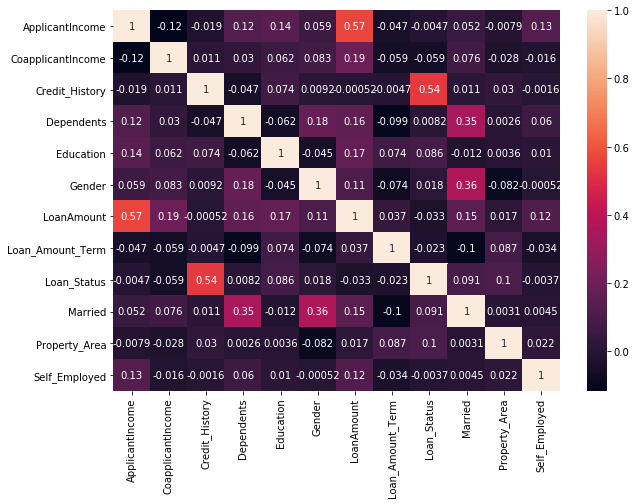

In [53]:
corr_check(train_data)

In [54]:
#calculating the actual loan amount
datas=[train_data,test_data]
for temp in datas:
    temp['Actual_loan_amount']=temp['LoanAmount']*temp['Loan_Amount_Term']
train_data['Actual_loan_amount'].head()


0    45360.0
1    46080.0
2    23760.0
3    43200.0
4    50760.0
Name: Actual_loan_amount, dtype: float64

In [55]:
for temp in datas:
    temp['Income_ratio']=temp['CoapplicantIncome']/temp['ApplicantIncome']
train_data['Income_ratio'].head()

0    0.000000
1    0.329042
2    0.000000
3    0.912892
4    0.000000
Name: Income_ratio, dtype: float64

In [56]:
for temp in datas:
    temp['ratio_income_term']=temp['ApplicantIncome']/temp['Loan_Amount_Term']
train_data['ratio_income_term'].head()

0    16.247222
1    12.730556
2     8.333333
3     7.175000
4    16.666667
Name: ratio_income_term, dtype: float64

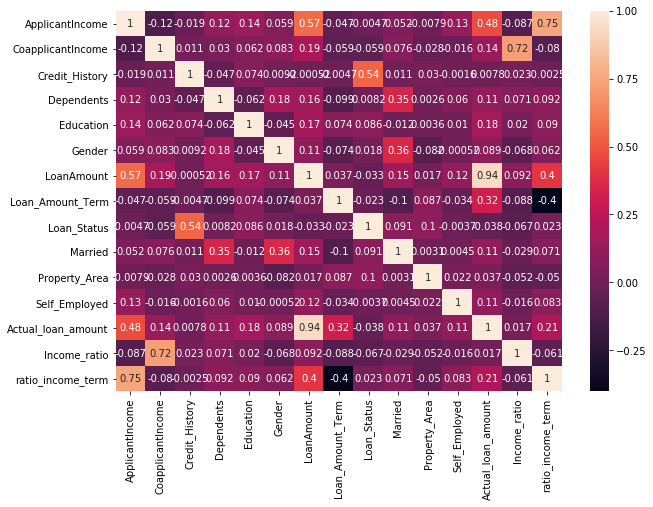

In [57]:
corr_check(train_data)

In [58]:
train_data.drop(['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term'],axis=1,inplace=True)
#train_data.drop(['LoanAmount','Loan_Amount_Term'],axis=1,inplace=True)

In [60]:
x=[x for x in train_data.columns if x not in target+id]
model_fit_train(models,train_data,test_data,x,target)

Logistic Regression : :
Precision Score : 0.687
 Recall_score :1.000
 F1 Score : 0.815
 Log Loss Score :10.801
 Accuracy score:0.687
Cross Value Score : Mean - 0.8291 | Std - 0.006414 | Min - 0.8231 | Max - 0.8367
------------------------------
KNeighborsClassifier : :
Precision Score : 0.751
 Recall_score :0.931
 F1 Score : 0.832
 Log Loss Score :8.944
 Accuracy score:0.741
Cross Value Score : Mean - 0.7714 | Std - 0.03341 | Min - 0.7184 | Max - 0.8478
------------------------------
SVC : :
Precision Score : 0.902
 Recall_score :1.000
 F1 Score : 0.948
 Log Loss Score :2.588
 Accuracy score:0.925
Cross Value Score : Mean - 0.817 | Std - 0.01957 | Min - 0.7746 | Max - 0.8424
------------------------------
Decision Tree : :
Precision Score : 0.790
 Recall_score :0.983
 F1 Score : 0.876
 Log Loss Score :6.582
 Accuracy score:0.809
Cross Value Score : Mean - 0.8994 | Std - 0.03274 | Min - 0.8231 | Max - 0.9504
------------------------------


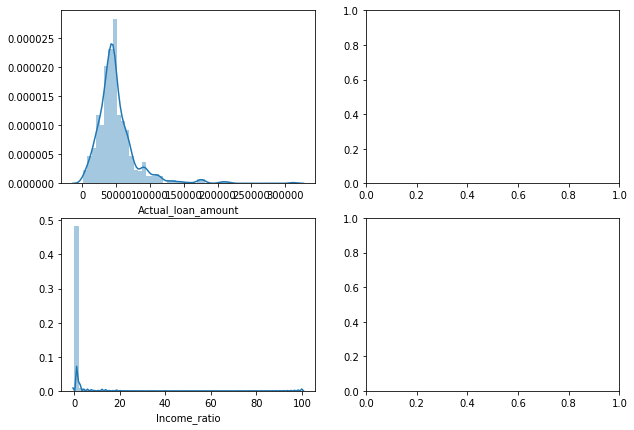

In [62]:
fig,ax=plt.subplots(2,2,figsize=(10,7))
sns.distplot(train_data['Actual_loan_amount'],ax=ax[0,0])
sns.distplot(train_data['Income_ratio'],ax=ax[1,0])

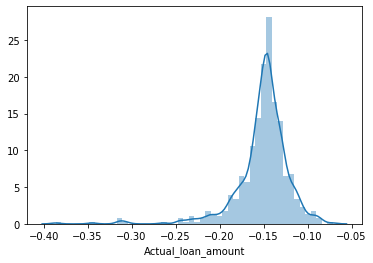

In [66]:
#Normalisation required, as the Actual_loan_amount is left sqewed
#Log normalisation is using
train_data['Actual_loan_amount']=np.log(train_data['Actual_loan_amount'])
sns.distplot(train_data['Actual_loan_amount'])

In [67]:
model_fit_train(models,train_data,test_data,x,target)

Logistic Regression : :
Precision Score : 0.793
 Recall_score :0.983
 F1 Score : 0.878
 Log Loss Score :6.469
 Accuracy score:0.813
Cross Value Score : Mean - 0.9012 | Std - 0.03391 | Min - 0.8231 | Max - 0.9504
------------------------------
KNeighborsClassifier : :
Precision Score : 0.778
 Recall_score :0.957
 F1 Score : 0.859
 Log Loss Score :7.482
 Accuracy score:0.783
Cross Value Score : Mean - 0.8253 | Std - 0.03529 | Min - 0.7303 | Max - 0.8799
------------------------------
SVC : :
Precision Score : 0.795
 Recall_score :0.986
 F1 Score : 0.880
 Log Loss Score :6.357
 Accuracy score:0.816
Cross Value Score : Mean - 0.8876 | Std - 0.02945 | Min - 0.8424 | Max - 0.9333
------------------------------
Decision Tree : :
Precision Score : 0.790
 Recall_score :0.983
 F1 Score : 0.876
 Log Loss Score :6.582
 Accuracy score:0.809
Cross Value Score : Mean - 0.8994 | Std - 0.03274 | Min - 0.8231 | Max - 0.9504
------------------------------
